# ***CS 512 S22: Computer Vision***
---
# **Illinois Institute of Technology**
# **Department of Computer Science**
# **Project: Recognizing human emotions with convolutional network**
---
# **Team Members:**
**Oleksandr Shashkov**\
**Amandeep Singh Oberoi**

**Checking for GPU.**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 17 01:55:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

IMPORTING LIBRARIES

In [2]:
import shutil 
import os, os.path
import glob
import pandas as pd
from keras import regularizers
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
import cv2
from PIL import Image, ImageFilter
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import layers
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


FER 2013: \
TOTAL CLASSES: 7 \
USE CASE: 48X48 GREYSCALE IMAGES FOR GESTURE RECOGNITION

In [28]:
# load data - replace data_path if needed
data_path = '/content/drive/MyDrive/fer2013.csv'
df = pd.read_csv(data_path, header=[0])
df = df.drop('Usage', 1)
print(df)
df.describe(include='all')
# EMOTIONS ARE ENCODED FROM 0-6 WITH 1D PIXEL ARRAY FOR IMAGES.

       emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  231 212 156 164 174 138 161 173 182 200 106 38...
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...        ...                                                ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...

[35887 rows x 2 columns]


,emotion,pixels
count,35887.000000,35887
unique,NaN,34034
top,NaN,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
freq,NaN,12
mean,3.323265,NaN
std,1.873819,NaN
min,0.000000,NaN
25%,2.000000,NaN
50%,3.000000,NaN
75%,5.000000,NaN


In [29]:
print(df.shape)
# TOTAL IMAGE COUNT 

(35887, 2)


In [30]:
df.columns

Index(['emotion', 'pixels'], dtype='object')

In [31]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

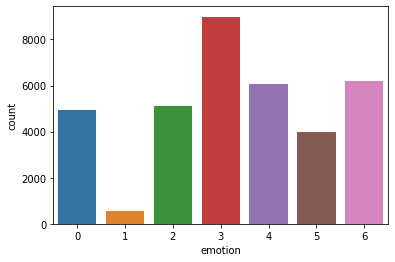

In [32]:
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'Fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
sns.countplot(x='emotion',data=df)
plt.show()
# IMABALANCED CLASSES OBSERVED
# CLASSES: 0: 'anger', 1: 'disgust', 2: 'Fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'

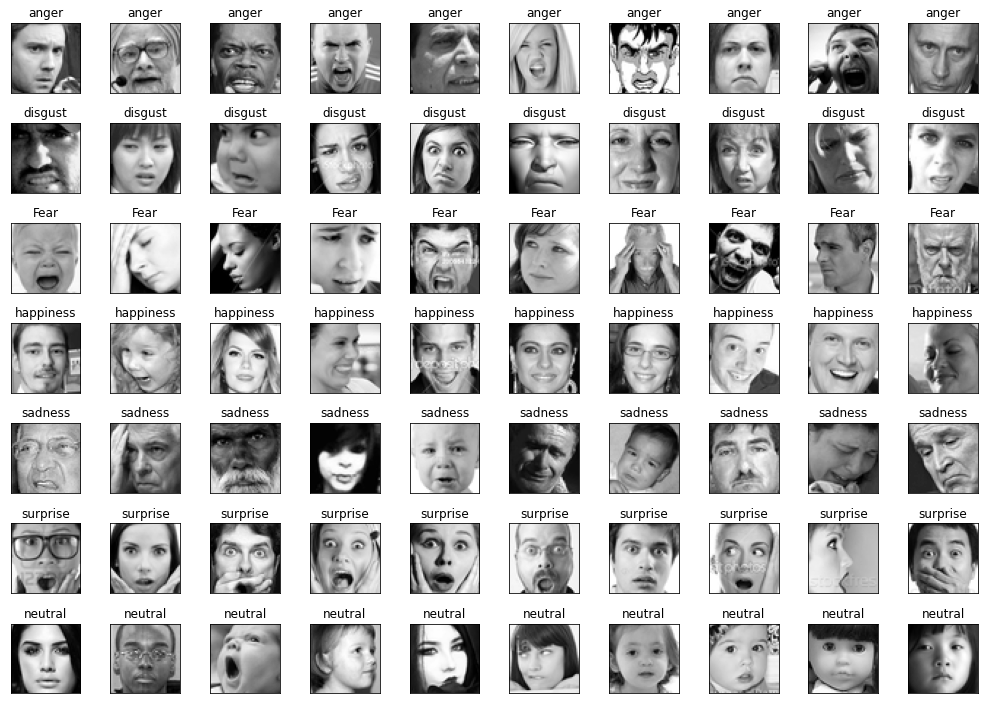

In [8]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(10):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(10, 10, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

# INITIAL VISUALIZATION OF OUR 7 CLASSES        

In [9]:
# RESHAPING TO FIT OUR MODEL (1 COLOR CHANNEL:GREYSCALE)
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [10]:
img_array.shape

(35887, 48, 48, 1)

In [11]:
# LABEL ENCODER USED FOR CLASSES
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [12]:
img_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [13]:
# PREPROCESSING IMAGES

1) GAUSSIAN BLUR: REMOVE NOISE,
2) UNSHARPED MASK: SHARPEN THE EDGES AND IMPROVE FEATURE DETECTION IN MODEL SUCH AS NOSE, EYE ETC,
3) HISTOGRAM EQULIZATION: ENHANCE CONTRAST

In [14]:
img_array[0].shape

(48, 48, 1)

In [15]:
equlization_images = []
for i in range(len(img_array)):
  smoothed = cv2.GaussianBlur(img_array[i], (15, 15), 1)
  # Guassian blur
  unsharped = cv2.addWeighted(img_array[i], 1.5, smoothed, -0.5, 0)
  # Unsharped masking
  img = np.array(unsharped, dtype=np.uint8)
  qu = cv2.equalizeHist(img)
  # histogram equilization
  equlization_images.append(qu)

In [16]:
pre1 = np.array(equlization_images)
pre1[0].shape

(48, 48)

In [17]:
pre_image = np.expand_dims(pre1, axis=-1)
# reshape
pre_image.shape

(35887, 48, 48, 1)

In [18]:
pre_image[0].shape

(48, 48, 1)

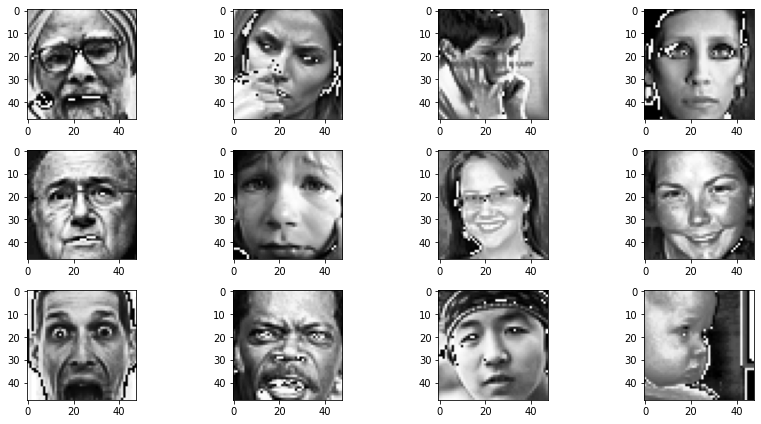

In [19]:
# RESULT AFTER PREPROCESSING IMAGES
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(pre_image[i, :, :, 0], cmap="gray")
plt.tight_layout()
plt.show()

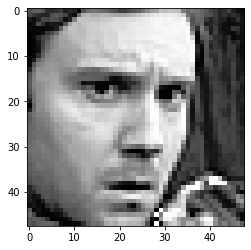

In [20]:
 plt.imshow(pre_image[0, :, :, 0], cmap="gray")
 plt.show()

In [21]:
img_labels[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [22]:
# TEST, TRAIN AND VALIDATION SPLIT
X_train, X_valid, y_train, y_valid = train_test_split(pre_image, img_labels, test_size=0.2)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((28709, 48, 48, 1),
 (3589, 48, 48, 1),
 (3589, 48, 48, 1),
 (28709, 7),
 (3589, 7),
 (3589, 7))

In [23]:
# IMAGES NORMALIZATION
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

In [24]:
# HANDLE UNBALANCED CLASSES BY GENERATING NEW IMAGES BY AUGMENTATION
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [27]:
def build_model(input_shape):
  input_image = tf.keras.layers.Input(shape=input_shape)
  input_tensor = tf.keras.layers.Concatenate()([input_image, input_image, input_image])
  x = tf.keras.layers.Resizing(96, 96)(input_tensor)
  input_shape = x.shape[1:]
  # Xception
  conv_base = tf.keras.applications.Xception(
      weights=None,
      include_top=False,
      input_shape=input_shape
      )
  # it trains well on our data so we just go for it!
  conv_base.trainable = True
  output_xception_conv = conv_base(x)
  # Customize the model adding fully-connected layers 
  x = tf.keras.layers.GlobalAveragePooling2D()(output_xception_conv)
  output_tensor = Dense(7, activation='softmax', name='predictions')(x)
  modelxception = tf.keras.models.Model(input_image,output_tensor)
  return modelxception

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 48, 48, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 resizing (Resizing)            (None, 96, 96, 3)    0           ['concatenate[0][0]']            
                                                                                              

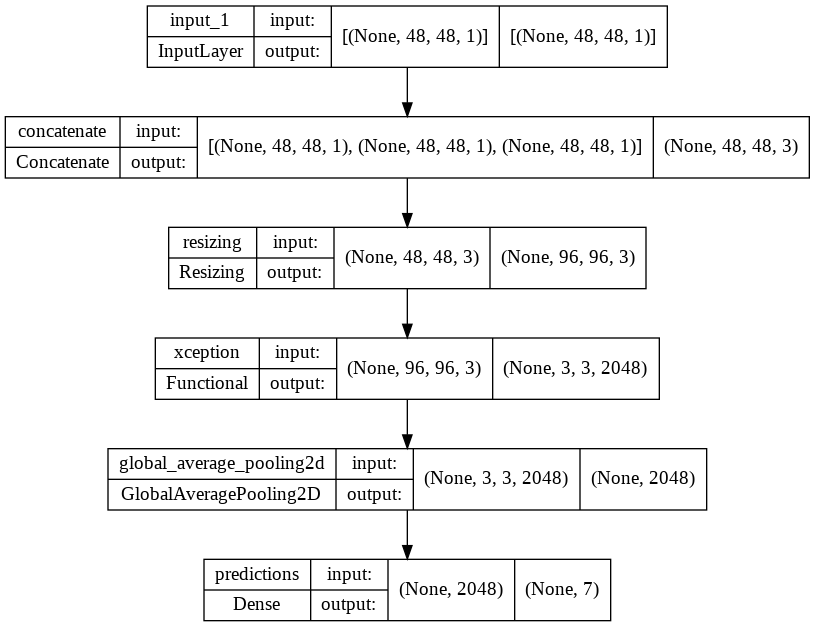

In [28]:
# BUILD MODEL AND DISPLAY ARCHITECTURE.
model = build_model((48, 48, 1))
model.summary()
tf.keras.utils.plot_model(model, to_file="/content/drive/MyDrive/model.png", show_shapes=True)
display(Image(filename="/content/drive/MyDrive/model.png"))

Epoch 1/200
224/224 [==============================] - 69s 273ms/step - loss: 2.0757 - accuracy: 0.2446 - val_loss: 6.6558 - val_accuracy: 0.2101 - lr: 0.0100
Epoch 2/200
224/224 [==============================] - 59s 265ms/step - loss: 1.8018 - accuracy: 0.2546 - val_loss: 1.8385 - val_accuracy: 0.2547 - lr: 0.0100
Epoch 3/200
224/224 [==============================] - 60s 265ms/step - loss: 1.7772 - accuracy: 0.2671 - val_loss: 1.8463 - val_accuracy: 0.2990 - lr: 0.0100
Epoch 4/200
224/224 [==============================] - 59s 261ms/step - loss: 1.7150 - accuracy: 0.3061 - val_loss: 4.0324 - val_accuracy: 0.2622 - lr: 0.0100
Epoch 5/200
224/224 [==============================] - 58s 261ms/step - loss: 1.6304 - accuracy: 0.3606 - val_loss: 2.1604 - val_accuracy: 0.2811 - lr: 0.0100
Epoch 6/200
224/224 [==============================] - 59s 261ms/step - loss: 1.5074 - accuracy: 0.4125 - val_loss: 11.9465 - val_accuracy: 0.2778 - lr: 0.0100
Epoch 7/200
224/224 [========================

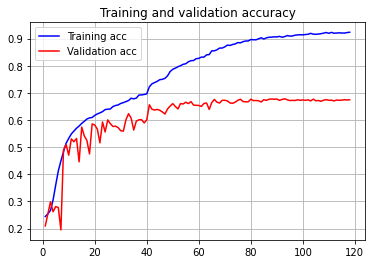

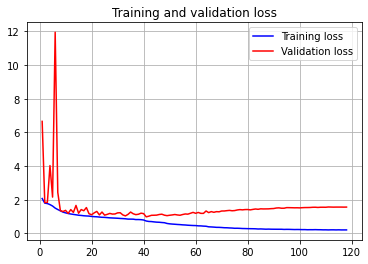

In [36]:
# MODEL TRAINING AND VALIDATION: PASSING PARAMTERS AND HYPERPARATMETERS
# setting up learning rate, epochs and batch size
lr = 0.01
epochs = 200
batch_size = 128
# loss: cross categorical entropy 
# optimiser: Adam
# metric: accuracy
model.compile(
    optimizer = Adam(learning_rate=lr),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )
# set up callback that would be saving best model
checkpoint_filepath = "./checkpoints/checkpoint.ckpt"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# early stopping: form of regularization used to avoid overfitting on bases of val_accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=25,
    verbose=1,
    restore_best_weights=True,
)
# Adaptive LR scheduler based on val_accuracy
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler,
    checkpoint_callback
]
# Fitting model on training data
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)
# load the best weights
model.load_weights(checkpoint_filepath)
# test final accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss: {0}, Test Accuracy: {1}'.format(test_loss, test_accuracy))
model.save("/content/drive/MyDrive/model") 
# PLOTTING MODEL GENERATED DATA
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.legend()
plt.show()

In [29]:
# test how the model loads and performs
del model
model = tf.keras.models.load_model("/content/drive/MyDrive/model")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss: {0}, Test Accuracy: {1}'.format(test_loss, test_accuracy))

113/113 [==============================] - 13s 21ms/step - loss: 0.4833 - accuracy: 0.8615
Test Loss: 0.4833182096481323, Test Accuracy: 0.861521303653717


### PREDICTING RESULTS ON A IMAGE (GESTURE RECOGNITION)

In [ ]:
# PREDICTING RESULTS ON A IMAGE (GESTURE RECOGNITION)

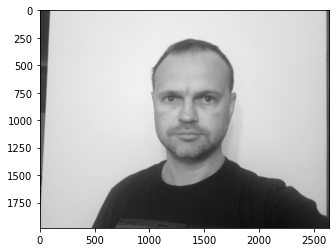

In [16]:
# SAMPLE IMAGE FOR TESTING THE PREDICTION OF OUR MODEL
img = cv2.imread("/content/drive/MyDrive/pic-1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#CONVERTED TO GREYSCALE
plt.imshow(gray,cmap='gray')
plt.show()

face_cascade: Object Detection Algorithm used to recognize faces in images or real-time video. The approach employs the edge or line detection characteristics described by Viola and Jones in their 2001 publication "Rapid Object Detection Using a Boosted Cascade of Simple Features."

In [17]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [18]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

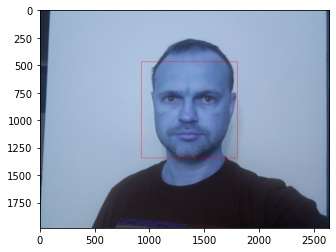

In [19]:
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]

plt.imshow(img,cmap='gray')
plt.show()

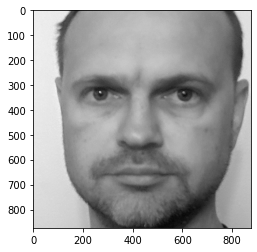

In [20]:
# FACE DETECTION COMPLETED FROM IMAGE
plt.imshow(roi_gray,cmap='gray')
plt.show()

In [21]:
roi_gray.shape

(874, 874)

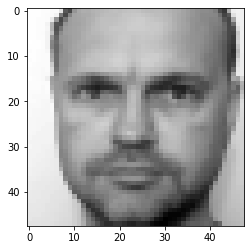

In [22]:
# RESCALED TO FIT OUR PREDICTION MODEL
img_scaled = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
img_scaled.shape
plt.imshow(img_scaled,cmap='gray')
plt.show()

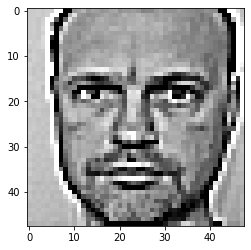

In [23]:
# IMAGE SHARPENING TO IMPROVE CONTRAST AND BETTER EDGE DETECTION
filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpen_img_1=cv2.filter2D(img_scaled,-1,filter)
plt.imshow(sharpen_img_1,cmap='gray')
plt.show()

In [24]:
# RESHAPE TO FIT MODEL
pre_image = np.expand_dims(sharpen_img_1, axis=-1)
pre_image.shape

(48, 48, 1)

In [25]:
pre_image = np.expand_dims(pre_image, axis=0)
pre_image.shape

(1, 48, 48, 1)

In [27]:
# PREDICTION OF CLASS (GESTURE) USING MODEL
model = tf.keras.models.load_model("/content/drive/MyDrive/model")
y_predict1 = model.predict(pre_image)
print(y_predict1)
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'Fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
print(emotion_label_to_text[np.argmax(y_predict1, axis=-1)[0]])
# CLASSES: 0: 'anger', 1: 'disgust', 2: 'Fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'

[[0. 0. 0. 0. 1. 0. 0.]]
sadness
